# Import Libraries

In [49]:
import numpy as np
import seaborn as sns
import pandas as pd  
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import PIL
from pathlib import Path
import os
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np
from imblearn.over_sampling import SMOTE

# Load & Preprocess Data

In [107]:
data_dir = "data/train"#directory of the  train data
test_dir = "data/test"#directory of the  test data

height,width=180,180#Size of the image
batch_size=32
train_dataset =tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(height,width),# resize images after they are read from folder
  batch_size=batch_size)#Size of the batches of data to load at a time

Found 8386 files belonging to 7 classes.
Using 6709 files for training.


In [108]:
val_dataset= tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(height,width),
  batch_size=batch_size)

Found 8386 files belonging to 7 classes.
Using 1677 files for validation.


In [109]:
test_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,#directory of the  test data
    shuffle = True,
    seed=123,
    image_size =(height,width),
    batch_size =batch_size  
)

Found 2201 files belonging to 7 classes.


In [110]:
class_names=train_dataset.class_names
print(class_names)

['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Eczema Photos', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Warts Molluscum and other Viral Infections']


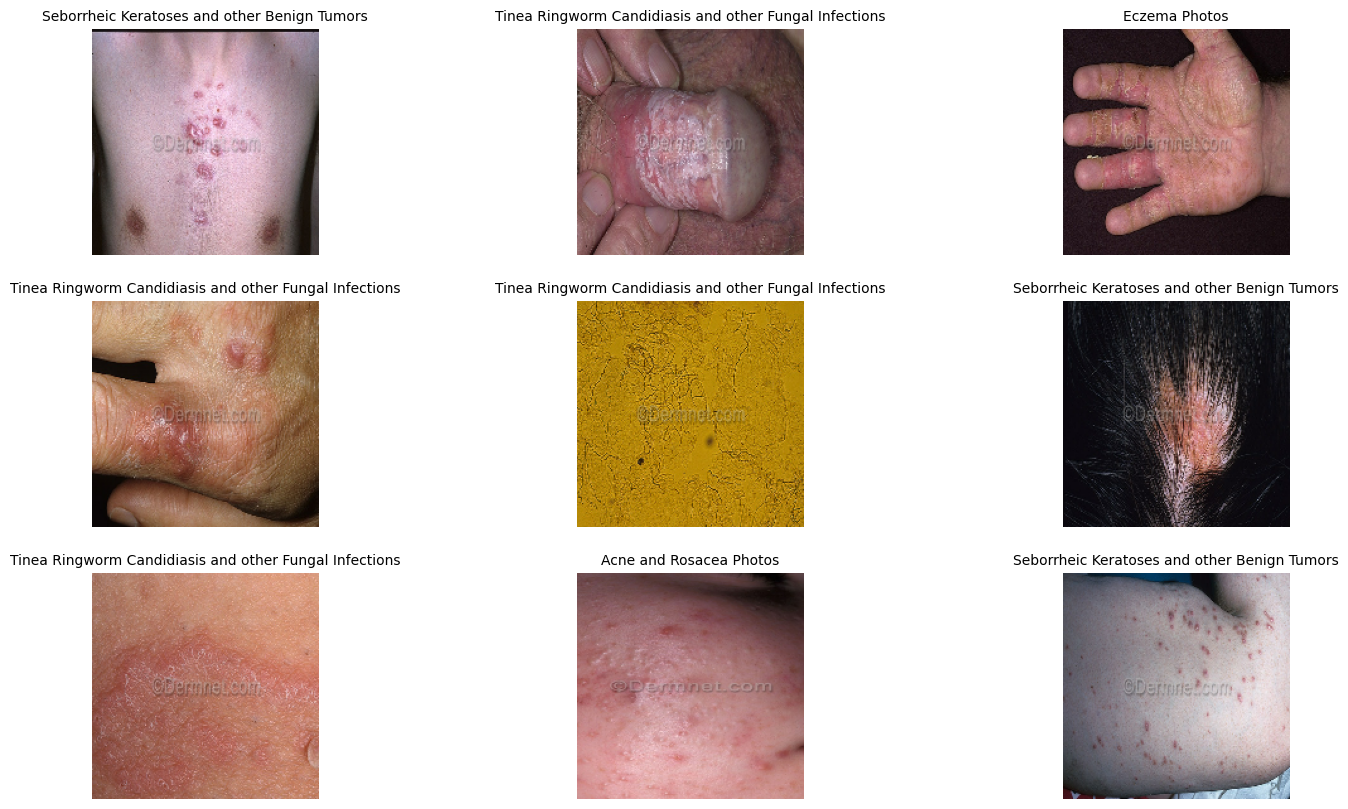

In [111]:
plt.figure(figsize = (10,10))#setting the size images in plot only
for images, labels in train_dataset.take(1):#looping through the dataset
   for i in range(9):
     ax = plt.subplot(3,3,i+1)
     plt.imshow(images[i].numpy().astype("uint8"))
     plt.title(class_names[labels[i]],fontsize = 10)
     plt.subplots_adjust(right =1.5)   
     plt.axis("off")

In [112]:
location = Path('data/train')
array = []
for folders in location.glob("*"):
    row = {}
    row["disease"] = folders.name.replace("Photos", "")
    list = os.listdir(folders) 
    countFiles = len(list)
    row["count"] =countFiles
    array.append(row)  
df=pd.DataFrame(array) 
print(df)

                                             disease  count
0                                  Acne and Rosacea     840
1  Actinic Keratosis Basal Cell Carcinoma and oth...   1149
2                                            Eczema    1235
3  Psoriasis pictures Lichen Planus and related d...   1405
4       Seborrheic Keratoses and other Benign Tumors   1371
5  Tinea Ringworm Candidiasis and other Fungal In...   1300
6         Warts Molluscum and other Viral Infections   1086


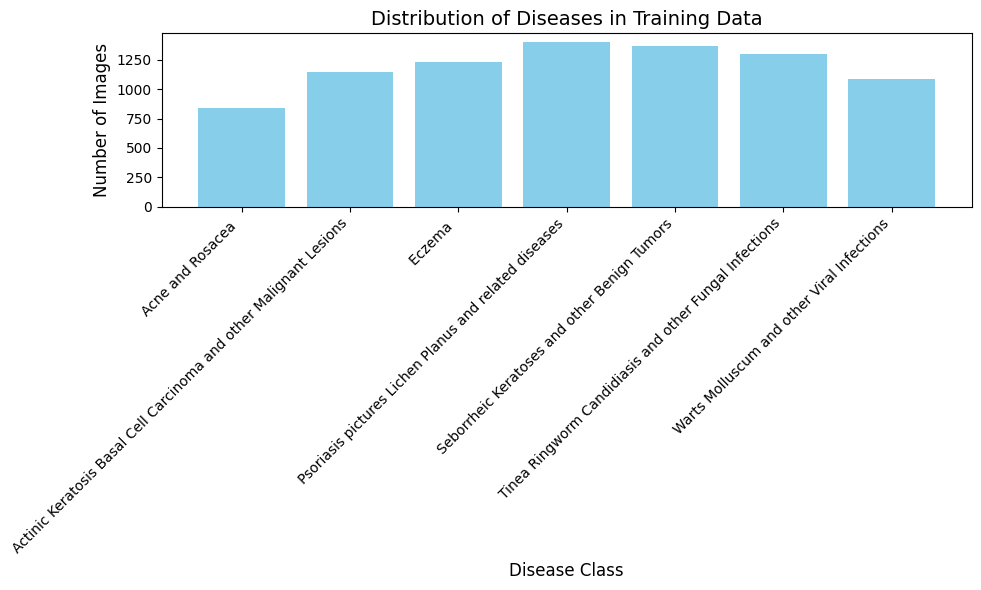

In [113]:
# Step 1: Plotting a Bar Chart
plt.figure(figsize=(10, 6))

# Step 2: Create the bar chart
plt.bar(df["disease"], df["count"], color='skyblue')

# Step 3: Adding labels and title
plt.xlabel('Disease Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Diseases in Training Data', fontsize=14)

# Step 4: Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Step 5: Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

# Load Model + Add Layers

In [114]:
model= Sequential()

resnet_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=7,
                   weights='imagenet')

for layer in resnet_model.layers:
        layer.trainable=False#freezing layers of the resnet model
     

In [115]:
model.add(resnet_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(7, activation='softmax'))#output layer

In [116]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [117]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [118]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_names),
    y=class_names
)

class_weights_dict = dict(enumerate(class_weights))

# Training

In [119]:
epochs=13
history=model.fit(train_dataset,validation_data=val_dataset,epochs=epochs,class_weight=class_weights_dict)

Epoch 1/13
210/210 ━━━━━━━━━━━━━━━━━━━━ 118s 545ms/step - accuracy: 0.3480 - loss: 1.8936 - val_accuracy: 0.4770 - val_loss: 1.3811
Epoch 2/13
210/210 ━━━━━━━━━━━━━━━━━━━━ 111s 530ms/step - accuracy: 0.5352 - loss: 1.2434 - val_accuracy: 0.4961 - val_loss: 1.3263
Epoch 3/13
210/210 ━━━━━━━━━━━━━━━━━━━━ 111s 530ms/step - accuracy: 0.6062 - loss: 1.0570 - val_accuracy: 0.5158 - val_loss: 1.2833
Epoch 4/13
210/210 ━━━━━━━━━━━━━━━━━━━━ 149s 711ms/step - accuracy: 0.6962 - loss: 0.8734 - val_accuracy: 0.5259 - val_loss: 1.2911
Epoch 5/13
210/210 ━━━━━━━━━━━━━━━━━━━━ 114s 541ms/step - accuracy: 0.7332 - loss: 0.7552 - val_accuracy: 0.5510 - val_loss: 1.2900
Epoch 6/13
210/210 ━━━━━━━━━━━━━━━━━━━━ 128s 610ms/step - accuracy: 0.7877 - loss: 0.6132 - val_accuracy: 0.5450 - val_loss: 1.3717
Epoch 7/13
210/210 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.8331 - loss: 0.4984 - val_accuracy: 0.5754 - val_loss: 1.3749
Epoch 8/13
210/210 ━━━━━━━━━━━━━━━━━━━━ 112s 532ms/step - accuracy: 0.8675 - lo

# Model Evaluation

Text(0.5, 1.0, 'Training and Validation Accuracy')

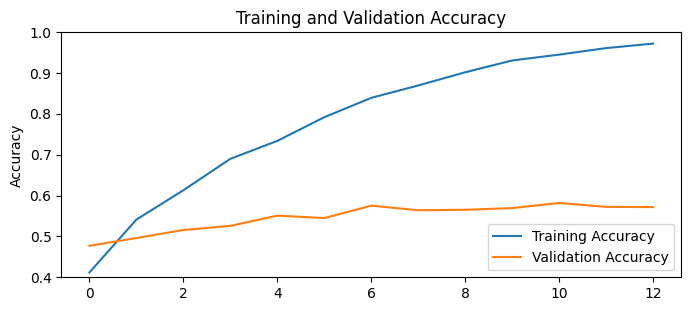

In [120]:
#plotting the learning curves training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 1)
plt.axis(ymin=0.4,ymax=1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

In [126]:
model.save("./model_v4.keras");

In [121]:
#testing model accuracy with the testing set(unbiased)
score =model.evaluate(test_dataset)
print('Test accuracy:', score[1])

69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 433ms/step - accuracy: 0.5954 - loss: 1.7187
Test accuracy: 0.5801908373832703


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


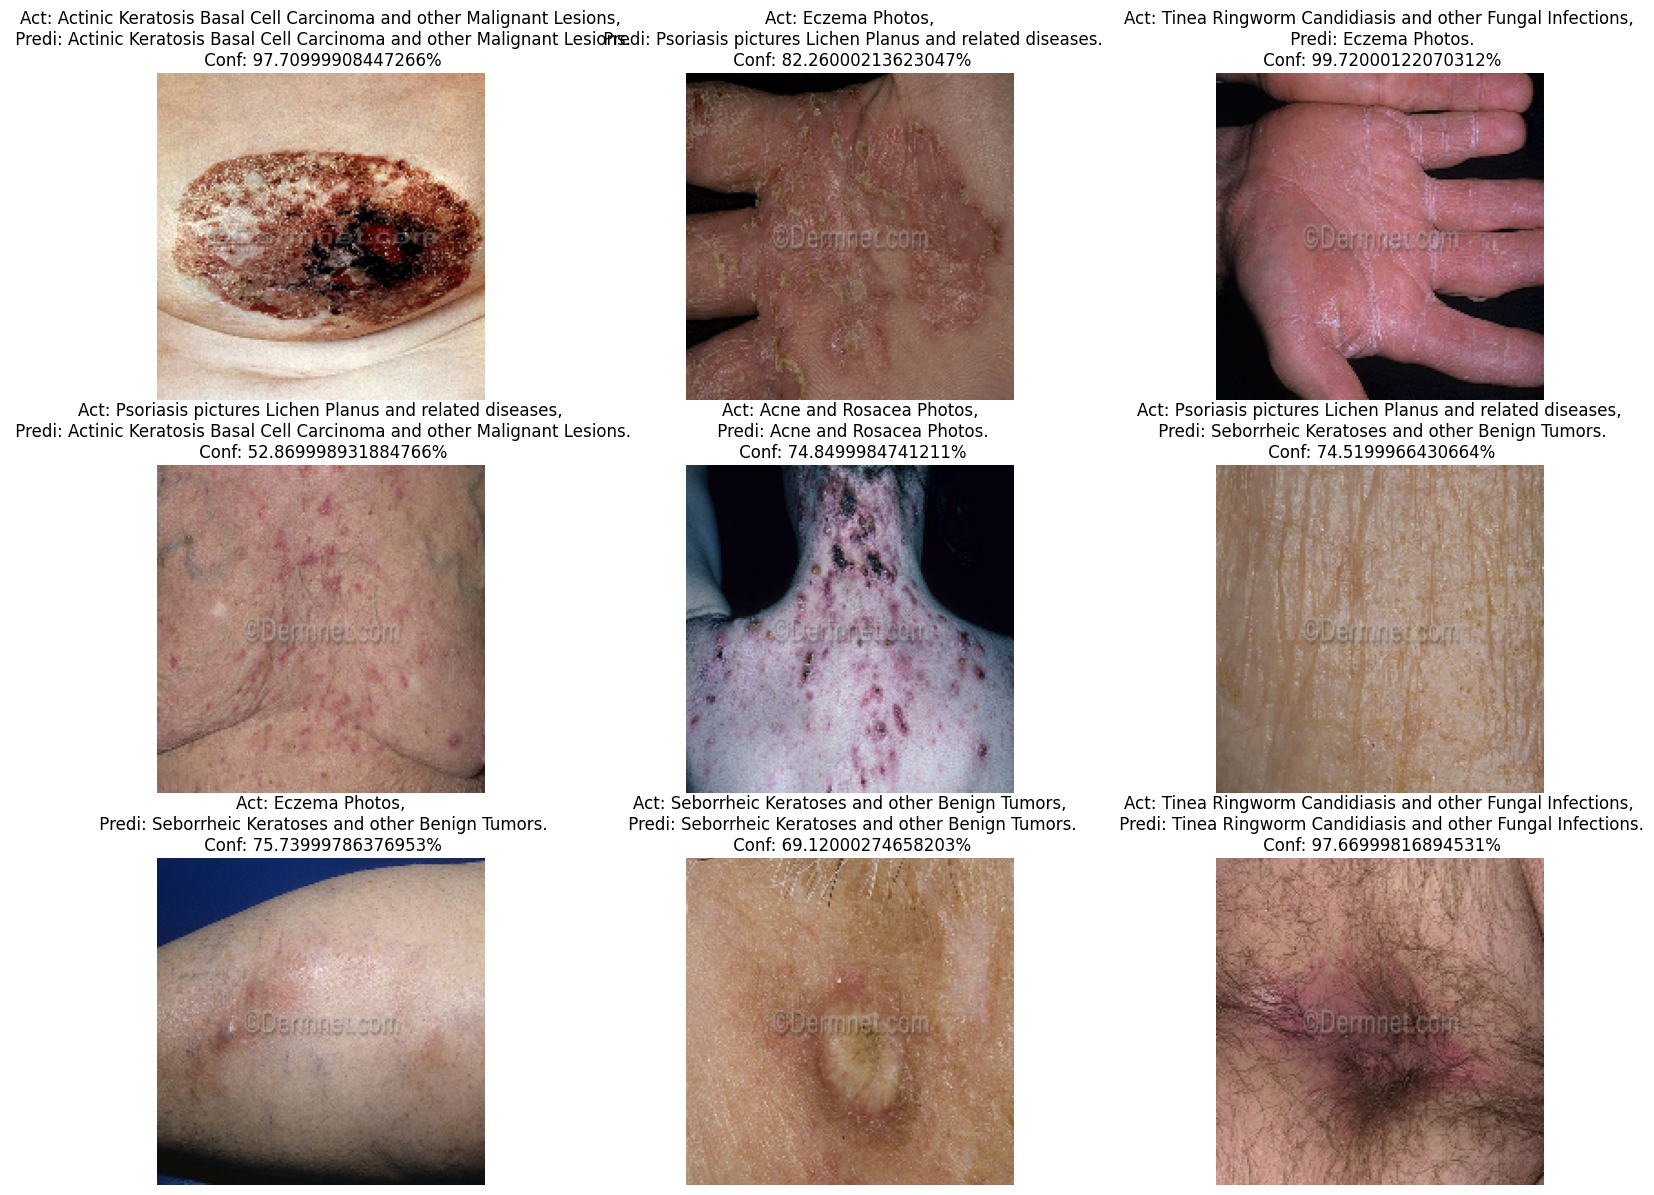

In [122]:
#predicting multiple images
def predict_image(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(8, 8))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict_image(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.subplots_adjust(right =2,top=1.5)
        plt.title(f"Act: {actual_class},\n Predi: {predicted_class}.\n Conf: {confidence}%")
        plt.axis("off")